In [1]:
from apl.data import read_data
from apl.prep.ohe import fitted_ohe
from apl.prep.prelim import xcolms, ycolm
from apl.prep.prep import preprocess, operations, sample
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression


In [2]:
df = read_data()
df.drop_duplicates(inplace=True)
df = df[xcolms+[ycolm]]
# fit ohe over all data
ohe = fitted_ohe(operations['oneHotEncode'], df)
data = sample(df, ycolm, 3, random_state=1234)

reading  /home/pranay/Desktop/apple/apl/data/data_exercise2.csv


In [3]:
from sklearn.model_selection import train_test_split
x,y = data, data['Failure']

xtrain, xtest, ytrain, ytest = train_test_split(
           x, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
xtrain.shape, ytrain.shape

((3430, 23), (3430,))

In [31]:
preprocessor = preprocess(operations, ohe, scale=True)

#pipeline
preprocessor.fit(xtrain)
xtrain = preprocessor.transform(xtrain)
clf = LogisticRegression(penalty='l1', solver='liblinear')

fitting...
transforming...


In [32]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, x, y, cv=cv, n_jobs=2, scoring=rms_error,
                       train_sizes=np.linspace(.1, 1.0, 5),
                       return_times=True, verbose=1)

[learning_curve] Training set sizes: [ 343 1114 1886 2658 3430]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   14.7s finished


In [33]:
import matplotlib.pyplot as plt

In [34]:
train_scores.shape

(5, 20)

In [35]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_scores_mean

array([0.54935783, 0.57034533, 0.57280177, 0.57099037, 0.57254655])

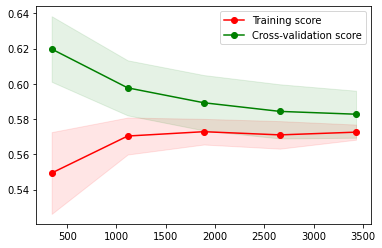

In [36]:
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best");

# Thus, no need of more data

# check for regularization paramter

In [35]:
from sklearn.model_selection import GridSearchCV


parameters = {'C':np.logspace(-2, 8, 8)}
search = GridSearchCV(clf, parameters, cv=cv, n_jobs=2, 
                      scoring=rms_error, verbose=1,
                     return_train_score=True)
search.fit(x, y)

Fitting 20 folds for each of 8 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  86 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:  1.3min finished


GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=0, test_size=0.2, train_size=None),
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=2,
             param_grid={'C': array([1.00000000e-02, 2.68269580e-01, 7.19685673e+00, 1.93069773e+02,
       5.17947468e+03, 1.38949549e+05, 3.72759372e+06, 1.00000000e+08])},
             return_train_score=True,
             scoring=<function rms_error at 0x7f8b8c107440>, verbose=1)

In [38]:
import pandas as pd
df = pd.DataFrame(search.cv_results_)
df[['param_C', 'mean_train_score', 'mean_test_score']]

,param_C,mean_train_score,mean_test_score
0,0.01,0.635427,0.638357
1,0.26827,0.578502,0.585671
2,7.19686,0.569830,0.579994
3,193.07,0.569072,0.580607
4,5179.47,0.569214,0.581063
5,138950,0.569239,0.581111
6,3.72759e+06,0.569201,0.581008
7,1e+08,0.569226,0.580861


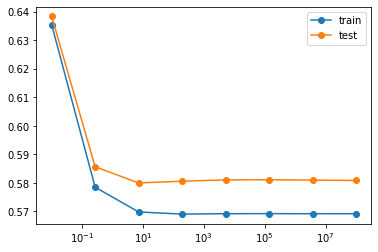

In [37]:
px, py = df['param_C'], df['mean_train_score']
plt.plot(px,py, 'o-', label='train')
px, py = df['param_C'], df['mean_test_score']
plt.plot(px,py, 'o-', label='test')
plt.xscale('log')
plt.legend();